# Installation 

* git clone https://git.ligo.org/otto.hannuksela/quintet.git .
* cd quintet .
* python setup.py install.

In [5]:
import numpy as np
import pylab as plt
from datetime import datetime

# modified Findchirp method, or Half Scaling method. 
* SNR : $$ \rho= \left( \frac{1 Mpc}{D_{eff}} \right)\mathcal{A}_{1Mpc} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

* Half scaled SNR : $$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right)\mathcal{A}_{1Mpc}^{-1} \times \rho $$
                    $$ \rho_{1/2} = \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$
                    
* It shouldn't depend on the GW parameters
* It depends on the noise curve of the detector : $S_n(f)$

# taking care of units
* $\mathcal{M}$ : chirp mass in $M_{\odot}$, $\mathcal{D}$: luminosity distance in Mpc. 
* $F_+,F_{\times}$: Antenna pattern, $\iota$: inclination angle
$$\mathcal{A}_{1Mpc}=\left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{\mathcal{M}}{M_{\odot}}\right)^{5/6} $$
$$ \mathcal{D}_{eff} = \mathcal{D}\left[ F_+^2\left(\frac{1+cos^2\iota}{2}\right)^2 + F_{\times}^2 cos^2\iota \right]^{-1/2} $$ 

* Half scaled SNR : 
$$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right) \mathcal{M}^{-5/6} \times \rho $$
$$ \rho_{1/2} = \left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{1}{M_{\odot}}\right)^{5/6} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

* Putting a upper integration limit at $f_{ISCO}$ lower limit to a chosen $f_{min}$
$$ f_{ISCO} = \frac{f c^3}{ G M_{tot}\pi 6^{3/2} } $$
$$ \rho_{1/2} = \left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{1}{M_{\odot}}\right)^{5/6} \sqrt{ 4\int_{f_{min}}^{f_{ISCO}} \frac{f^{-7/3}}{S_n(f)}df } $$

In [3]:
from quintet import Quintet as quin

In [9]:
# nsamples is use for fitting. default: nsamples=100
# nsamples with higher value will give better result.
# for BNS events nsamples can be kept low
start_time = datetime.now()
quin_ = quin(nsamples=200)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:14.860992


## simple performance checks
* the taylorF2 results are trucated at the f_max

In [10]:
# Bilby
quin_.compute_bilby_snr_(mass_1=np.array([10.,50.,100.,500.]), mass_2=np.array([10.,50.,100.,500.]))

{'opt_snr_net': array([161.52595333, 315.6661989 ,  78.9002118 ,   0.        ]),
 'L1': array([132.08275995, 261.76879278,  65.69651976,   0.        ]),
 'H1': array([ 84.00372897, 166.48315594,  41.78253576,   0.        ]),
 'V1': array([39.85162032, 58.35757916, 12.78399073,  0.        ])}

In [11]:
# with interpolation
quin_.snr(mass_1=np.array([10.,50.,100.,500.]), mass_2=np.array([10.,50.,100.,500.]))

{'opt_snr_net': array([161.52738209, 315.45992778,  79.22605024,   0.        ]),
 'L1': array([132.08397565, 261.60173155,  65.96882784,   0.        ]),
 'H1': array([ 84.00450215, 166.37690615,  41.95572183,   0.        ]),
 'V1': array([39.85175228, 58.29429808, 12.8295828 ,  0.        ])}

* notice how SNR decrease with mass
* mtot=1000 has $f_{lso}(f_{max})$ below 20Hz
* last stable orbit's frequency is calculated as, $f_{lso} = \frac{C^3}{ G(m_{tot})M_\odot\pi 6^{3/2} }$

# speed test
* bilby Vs interpolation with half SNR

In [20]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 1000
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [21]:
# error might occur for mchirp>95., if f_min=20. 
start_time = datetime.now()
bilby_ = quin_.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:50.929154


In [15]:
50.229082*1000/3600

13.952522777777776

* here is bilby is faster than usual as I have initialized the interferometer objects and PSDs commonly 
* also TaylorF2 is fast
* for 1 miilion points it will take ~14hrs

In [14]:
start_time = datetime.now()
mine_ = quin_.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, iota=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.023521


In [17]:
50.229082/00.023521

2135.499426044811

In [16]:
00.023521*1000

23.521

* mine is 2135.499426044811 times faster than that of bilby's
* for 1 miilion points it will take ~24s

## Accuracy checks
* SNR difference

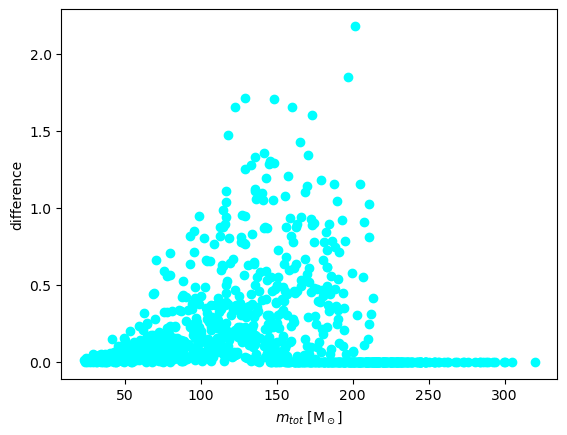

In [22]:
plt.plot(total_mass, abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
plt.show()

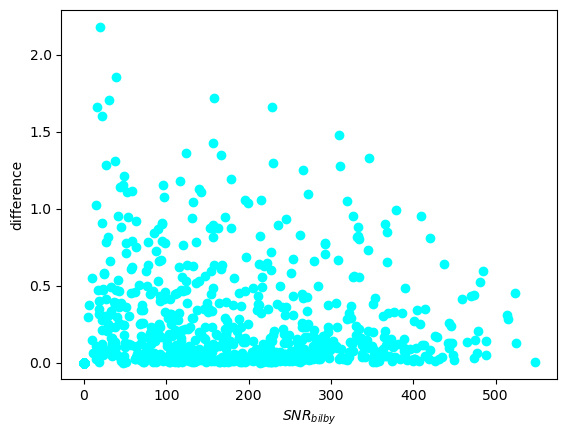

In [23]:
plt.plot(bilby_['opt_snr_net'], abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$SNR_{bilby}$")
plt.ylabel(r"difference")
plt.show()

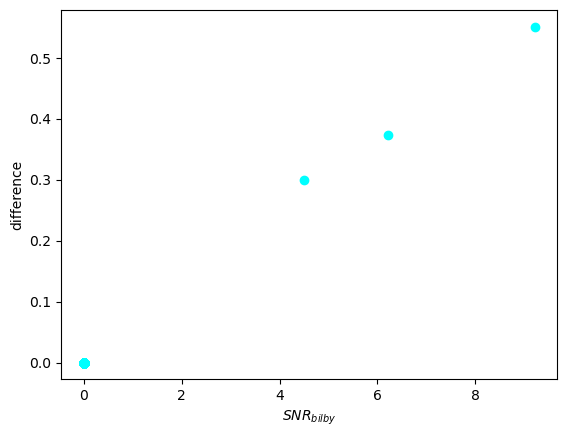

In [26]:
# for SNR below 10
# SNR>8 is considered detectable
idx = bilby_['opt_snr_net']<10
xx =  bilby_['opt_snr_net'][idx]
yy = abs(mine_['opt_snr_net']-bilby_['opt_snr_net'])[idx]
plt.plot(xx, yy, 'o', color='cyan')
plt.xlabel(r"$SNR_{bilby}$")
plt.ylabel(r"difference")
plt.show()

* close enough

## Accuracy checks in BNS events
* SNR difference

In [28]:
quin_ = quin(mtot_min=1., mtot_max=8., nsamples=50)

In [30]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20.
nsamples = 1000
chirp_mass = np.linspace(1,3,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [31]:
start_time = datetime.now()
bilby_ = quin_.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)

mine_ = quin_.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, iota=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:58.993349


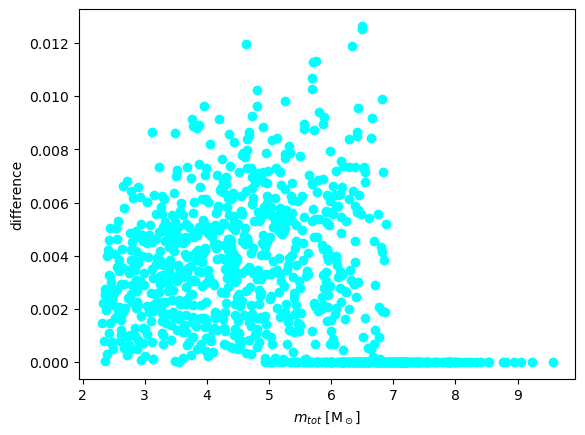

In [32]:
plt.plot(total_mass, abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
plt.show()

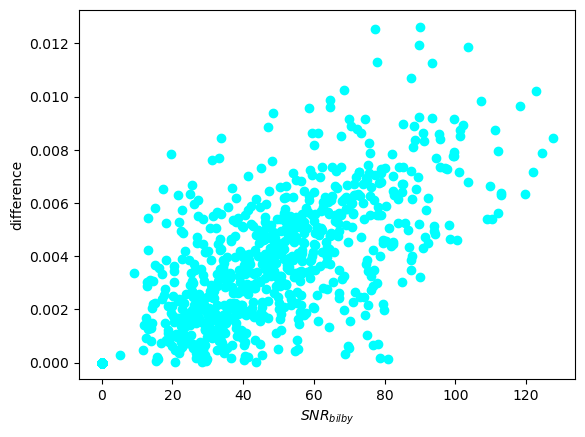

In [33]:
plt.plot(bilby_['opt_snr_net'], abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$SNR_{bilby}$")
plt.ylabel(r"difference")
plt.show()

* a satisfying result